# Project for the Kaggle competition to explore passenger data from the Titanic disaster aimed at generating a binary classifier to predict survival of individuals.

This is a polished version of the "working" file, which omits much of the data exploration.

In [63]:
# importing
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%matplotlib inline

In [3]:
# define some functions that will be used for data manipulation

def male_female_child(passenger):
    age, sex = passenger
    
    if age < 16:
        return 'child'
    else:
        return sex

In [4]:
# Load data already downloaded from Kaggle and saved into this notebook's folder
titanic_df = pd.read_csv('train.csv')

In [5]:
# Explore the data a bit.
# PassengerId : one based counting of passengers
# Survived : logical if passenger survived disaster
# Pclass : Passenger's class ranging from 1-3, with 1 = the highest (first) class
# Name : recorded name (not going to use but interesting to look at)
# Sex : gender
# Age : age in years
# SibSp : Was the passenger traveling with a sibling
# Parch : "parent/child" was the passenger traveling with a parent or child
# Ticket : recorded ticket number
# Fare : cost of ticket
# Cabin : room number (many of these values are missing from historical records)
# Embark : city the passenger boarded from, S - C - Q

titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


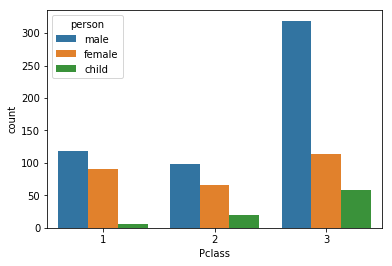

In [6]:
# Create a new column which defines an individual as a male, female, or a child
# Used later for the classification
titanic_df['person'] = titanic_df[['Age', 'Sex']].apply(male_female_child, axis = 1)
# And plot results to see the breakdown of passenger counts based on class
sns.countplot("Pclass", data = titanic_df, hue = "person")

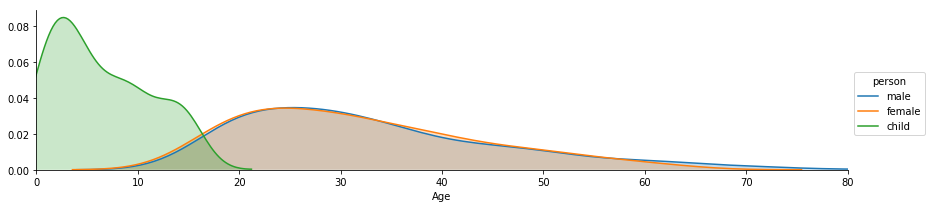

In [7]:
# Nice example plot showing the distribution of passenger gender by age
fig = sns.FacetGrid(titanic_df, hue = 'person', aspect = 4)
fig.map(sns.kdeplot, 'Age', shade = True)

fig.set(xlim = (0, titanic_df['Age'].max()))
fig.add_legend()

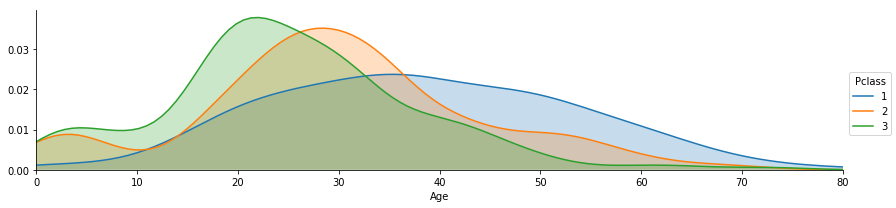

In [8]:
# And then by class
fig = sns.FacetGrid(titanic_df, hue = 'Pclass', aspect = 4)
fig.map(sns.kdeplot, 'Age', shade = True)

fig.set(xlim = (0, titanic_df['Age'].max()))
fig.add_legend()

# Now to try and understand where people were staying on the titanic based on their cabin position

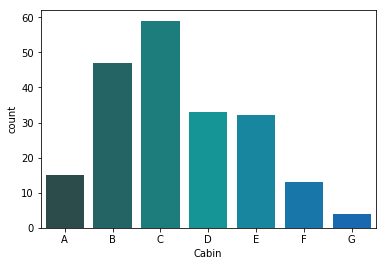

In [9]:
# Munge through the "cabin" column

# First get rid of all NaNs and drag along some other columns for later analysis
deck = titanic_df['Cabin'].dropna()
surv = titanic_df['Survived'][deck.index]
gend = titanic_df['Sex'][deck.index]

# Next we only want to know the deck level, not the particular room number, 
# so just grab the first letter for each value
levels = [l[0] for l in deck]

# Convert to a dataframe
cabin_df = DataFrame({'Survived': surv, 'Cabin':levels, 'Sex':gend})

# You will notice with a little exploration we have a strange "T" Value from passenger 339.
# This value must be an error, so we should remove it
cabin_df = cabin_df[cabin_df.Cabin != 'T']

# Then we can plot out the histogram. Making sure things come out in a logical order
order = [l for l in np.unique(cabin_df['Cabin'])]
sns.countplot('Cabin', data = cabin_df, order = order, palette = 'winter_d')

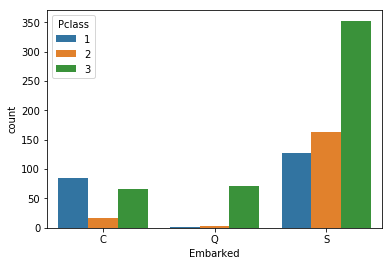

In [10]:
# Lastly lets also take a look at where the passengers came from
sns.countplot('Embarked', data = titanic_df, hue = 'Pclass', order = ['C', 'Q', 'S'])

Looks like some interesting differences in populations for each city. A subsequent question might be what economic conditions exist in each city to explain the primarily 3rd class passengers from Queenstown, higher percentage of first class passengers from Cherbourg, and greater total number from Southhampton.

# Now lets look into people traveling with or without family members

C:\Users\penalab\Anaconda2\envs\py36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


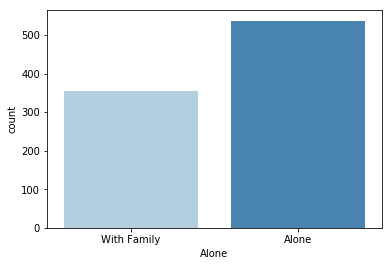

In [11]:
# Create a new column that binarily states if a person is traveling alone or with family members
# We can estimate this by using the number of siblings or parents/children accompanying each passenger
titanic_df['Alone'] = titanic_df.SibSp + titanic_df.Parch

titanic_df['Alone'].loc[titanic_df['Alone'] > 0] = 'With Family'
titanic_df['Alone'].loc[titanic_df['Alone'] == 0] = 'Alone'
# Error message has to be with being careful manipulating original or copied data. For now we will ignore

# And a little plot
sns.countplot('Alone', data = titanic_df, palette = "Blues")

# Next we will generate some plots to get a feeling for how various factors influenced survival chances

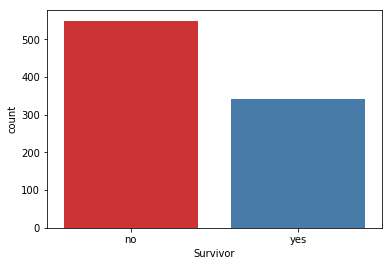

In [12]:
# How many people survived vs perished?
titanic_df['Survivor'] = titanic_df.Survived.map({0: 'no', 1: 'yes'})
sns.countplot('Survivor', data = titanic_df, palette = 'Set1')

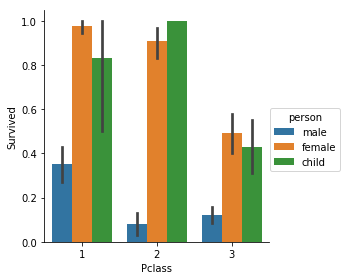

In [13]:
# What about survival rates in different classes and gender?
sns.factorplot(x = 'Pclass', y = 'Survived', data = titanic_df, hue = 'person', kind = 'bar')

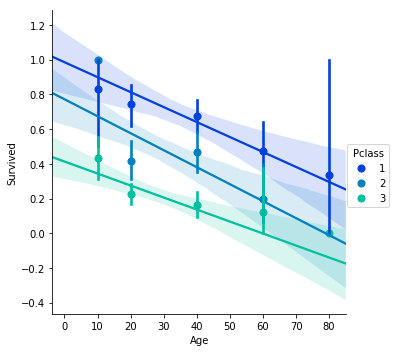

In [14]:
# How did different classes fair vs age?
generations = [10, 20, 40, 60, 80]
sns.lmplot('Age', 'Survived', hue = 'Pclass', data = titanic_df, palette = 'winter', x_bins = generations)

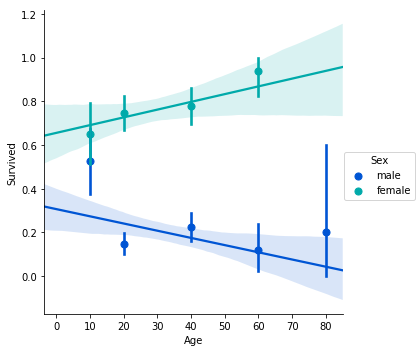

In [15]:
# And what about different genders with age?
sns.lmplot('Age', 'Survived', hue = 'Sex', data = titanic_df, palette = 'winter', x_bins = generations)

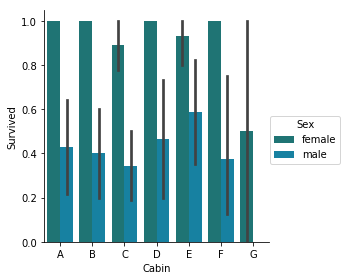

In [16]:
# What about where the passengers stayed on the ship? And if we include gender differences?
order = [l for l in np.unique(cabin_df['Cabin'])]
sns.factorplot('Cabin', 'Survived', hue = 'Sex', data = cabin_df, order = order, palette = 'winter_d', kind = 'bar')

This plot is interesting because it actually suggests where on the ship you were made no difference. However we ought to also investigate just how many values were omitted from this analysis due to mising data. Perhaps we would not want to use these data because of how incomplete the set is.

There is likely a strong correlation with cabin level and passenger class. Therefore the previously performed class analysis is likley just as informative is not better!

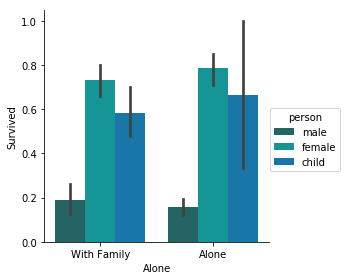

In [17]:
# And what about if the passenger was traveling alone or with family?
sns.factorplot('Alone', 'Survived', hue = 'person', data = titanic_df, palette = 'winter_d', kind = 'bar')

# Now that the initial munging and characterization plots are complete we need to perform the classification

We will use a linear discriminant analysis. 

In [27]:
# rearrange the data a bit to get training data
alone = titanic_df.Alone.map({'With Family': 0, 'Alone': 1})
gender = titanic_df.Sex.map({'male': 0, 'female': 1})

X_train = titanic_df[['Pclass', 'Age', 'Survived']]
X_train['Sex'] = Series(gender)
X_train['Alone'] = Series(alone)
X_train = X_train.dropna()
y_train = X_train['Survived']
X_train = X_train.drop(columns = ['Survived'])

C:\Users\penalab\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\penalab\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [28]:
# Then load in the test data from the file provided by Kaggle

test = pd.read_csv('test.csv')

test['Alone'] = test.SibSp + test.Parch
alone = []
for l in test.Alone:
    if l == 0:
        alone.append(1)
    else:
        alone.append(0)
alone = Series(alone)
gender = titanic_df.Sex.map({'male': 0, 'female': 1})

X_test = test[['Pclass', 'Age']]
X_test['Sex'] = Series(gender)
X_test['Alone'] = Series(alone)
X_test = X_test.dropna()

C:\Users\penalab\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\penalab\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
# Run the fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis().fit(X_train, y_train)

# This is result is what we would submit to Kaggle
y_test = lda.predict(X_test)

In [30]:
# For a demonstration of the potential accuracy we might get when we submit

# Keep the original training sets in place
X = X_train
Y = y_train

import sklearn

# Break up data into training and test sets
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

# Calculate the fit
lda = LinearDiscriminantAnalysis().fit(X_train, Y_train)

# Make predictions
pred_train = lda.predict(X_train)
pred_test = lda.predict(X_test)

print(" Accuracy Train: %.2f " % np.mean(pred_train == Y_train))
print(" Accuracy Test: %.2f " % np.mean(pred_test == Y_test))

 Accuracy Train: 0.79 
 Accuracy Test: 0.78 


## Classifier with Bootstrap cross-validation

In [66]:
# To get a feel for how reproducible the accuracy is, perform the above multiple times using a bootstrapping cross-validation

X['Survived'] = Y
data = X

reps = 100

train_acc = []
test_acc = []

boot_perc = 0.7

num_train = int(np.round(len(data) * boot_perc))
num_test = int(np.round(len(data) * (1 - boot_perc)))

for i in range(reps):
    
    clear_output()
    print(i)
    
    train = sklearn.utils.resample(data, replace = True, n_samples = num_train)
    test = sklearn.utils.resample(data, replace = True, n_samples = num_test)

    X_train = train.drop(columns = ['Survived'])
    Y_train = train['Survived']
    X_test = test.drop(columns = ['Survived'])
    Y_test = test['Survived']

    lda = LinearDiscriminantAnalysis().fit(X_train, Y_train)
    pred_train = lda.predict(X_train)
    pred_test = lda.predict(X_test)

    train_acc.append(np.mean(pred_train == Y_train))
    test_acc.append(np.mean(pred_test == Y_test)) 
    
clear_output()
print('Done!')

Done!


Text(0.5,1,'Classifier accuracy with bootstrapping')

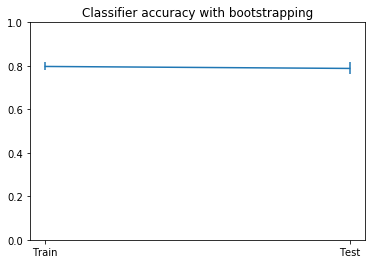

In [72]:
# Quick simple plot showing the accuracy of the classifier is highly consistent regardless of what portion of the data are used
plt.errorbar(['Train', 'Test'], [np.mean(train_acc), np.mean(test_acc)], [np.std(train_acc), np.std(test_acc)])
plt.ylim([0, 1])
plt.title('Classifier accuracy with bootstrapping')